\centerline{***Project Automatic classification of skin lesions(melanoma detection)***}

\centerline{Hamza AIT BAALI}

The objective of this project is to propose a methodology for the automatic
classification of skin lesions, based on image analysis and machine learning.

# PART 1 : Description of the Database and preprocessing

Here is a sample of the images we are willing to process (Original image of skin lesion and the segmented image) :

| Original image | segmented image |
|------|------|
| ![PROJECT_Data/PROJECT_Data/ISIC_0000000.jpg](PROJECT_Data\PROJECT_Data\ISIC_0000000.jpg) | ![PROJECT_Data/PROJECT_Data/ISIC_0000000_segmentation.png](PROJECT_Data\PROJECT_Data\ISIC_0000000_segmentation.png) |


We dispose also of the segmentation of the original images using super-pixels, these last ones will be used later with geometrical descriptors on Python.
Our database is composed of 200 samples, which are part of a 2000 original database from the world wide challenge : "ISIC 2017 : Skin Lesion Analysis Towards Melanoma Detection". in order to load all the images and assign to each one of them their corresponding labels, the script here in this report is well commented explaining every part of this process.

In [1]:
import numpy as np

from sklearn.model_selection import train_test_split
#from sklearn.model_selection import ShuffleSplit

#Feature selection libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import statistics as st

import random

import matplotlib.pyplot as plt

#Image processing libraries
import cv2
import skimage.measure as sm

#Dataframes
import pandas as pd

#Machine learning libraries
import seaborn as sns; sns.set()

import sklearn.tree
import sklearn.neighbors

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score

#Deep learning library : Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

***
## Import labels

In [2]:
address = r'D:\Users\harti\Desktop\Mines Saint Etienne\toolbox3 Image and pattern recognition\Applications\Project (skin lesion classification)-20201127'
labels = pd.read_csv(address + r'\ISIC-2017_Data_GroundTruth_Classification.csv')

In [3]:
labels

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0
...,...,...,...
1995,ISIC_0015220,0.0,1.0
1996,ISIC_0015233,0.0,1.0
1997,ISIC_0015260,0.0,1.0
1998,ISIC_0015284,1.0,0.0


## Loading Data

In [ ]:
k = 0
X_original = [] #Original images
X_r = [] #Their red component for the cnn
X_segmented = [] #Segmented images
X_superpixels = [] #Superpixels
indexes = []
Y = [] #Labels vector
for i in range(519):
    if (i < 10):
        name = address + r'\PROJECT_Data\PROJECT_Data\ISIC_000000' + str(i)
        I = cv2.imread(name + '.jpg')
        J = cv2.imread(name + '_segmentation.png', cv2.IMREAD_GRAYSCALE)
        S = cv2.imread(name + '_superpixels.png')
        N = 'ISIC_000000' + str(i)
    elif (i < 100):
        name = address +  r'\PROJECT_Data\PROJECT_Data\ISIC_00000' + str(i)
        I = cv2.imread(name + '.jpg')
        J = cv2.imread(name + '_segmentation.png', cv2.IMREAD_GRAYSCALE)
        S = cv2.imread(name + '_superpixels.png')
        N = 'ISIC_00000' + str(i)
    else:
        name = address + r'\PROJECT_Data\PROJECT_Data\ISIC_0000' + str(i)
        I = cv2.imread(name + '.jpg')
        J = cv2.imread(name + '_segmentation.png', cv2.IMREAD_GRAYSCALE)
        S = cv2.imread(name + '_superpixels.png')
        N = 'ISIC_0000' + str(i)
    if (I is None):
        #in case of corresponding image of 'i' is missing
        print('fichier inexistant')
    else:
        #in case of corresponding image of 'i' is found
        k=1
    if (k == 1):
        indexes.append(i)
        k = 0
        print(i) #Useful for debeugguing
        
        X_original = X_original + [cv2.resize(src=I,dsize=(767,1022))]
        
        I_r = np.array(I[:,:,2])
        X_r = X_r + [cv2.resize(src=I_r,dsize=(112,84))]
        
        X_segmented = X_segmented + [255-J]
        
        X_superpixels = X_superpixels + [S]
        
        #Extract corresponding label
        for j in range(2000):
            if (labels['image_id'][j]==N):
                Y = Y + [int(labels['melanoma'][j])]; 
                break
#Classes names for better visualisations
class_names = ['benign','melanoma']

The loading step has been done in  Python. Here is a sample from the Database loaded and labelled in Python

### A sample of original images labelled

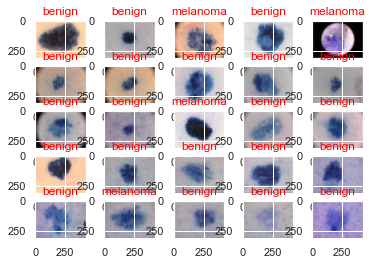

In [5]:
fig=plt.figure()
for i in range(25):
    a=fig.add_subplot(5,5,i+1)
    a.set_title(class_names[Y[i]],color='red')
    plt.imshow(cv2.resize(X_original[i], (420, 312)))
plt.show()

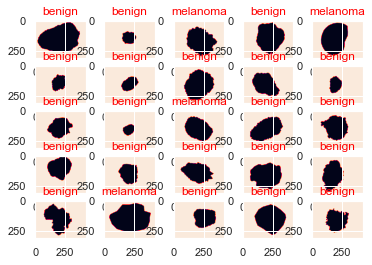

In [6]:
fig=plt.figure()
for i in range(25):
    a=fig.add_subplot(5,5,i+1)
    a.set_title(class_names[Y[i]],color='red')
    plt.imshow(cv2.resize(X_segmented[i], (420, 312)))
plt.show()

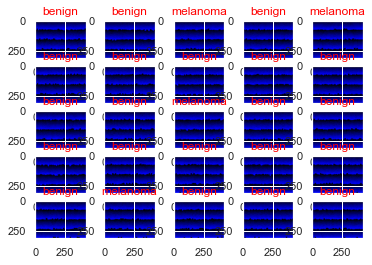

In [7]:
fig=plt.figure()
for i in range(25):
    a=fig.add_subplot(5,5,i+1)
    a.set_title(class_names[Y[i]],color='red')
    plt.imshow(cv2.resize(X_superpixels[i], (420, 312)))
plt.show()

***
We will now take profit of several machine learning models in order to achieve a good accuracy in our classification problematic, the steps of the different methods used will not be detailed as much as in the first project, still the scripts attached are very well commented.

# Classification using geometrical descriptors (RegionProps) + Color irregularity (number of superpixels) :

In [8]:
train_images = X_segmented
train_labels = Y

Analogically with the first project, the geometrical descriptors will be computed on the segmented images. Python has a library skimage.measure that contains a function regionprops_table that computes all possible geometric descriptors for binary images : area, bbox_area, convex_area, eccentricity, equivalent_diameter, extent, major_axis_length, minor_axis_length, perimeter.


## Geometric descriptors
We will now describe our images geometrically using the region props function

In [9]:
imgdata=np.zeros((200,9))
print('Compute region props')
for i in range(200):
    #All poSsible properties were taken into consideration
    props = sm.regionprops_table(train_images[i], properties=['area', 
                                'bbox_area','convex_area','eccentricity',
                                'equivalent_diameter','extent',
                                'major_axis_length','minor_axis_length',
                                'perimeter'])
    imgdata[i][0]=float(props['area'])
    imgdata[i][1]=float(props['bbox_area'])
    imgdata[i][2]=float(props['convex_area'])
    imgdata[i][3]=float(props['eccentricity'])
    imgdata[i][4]=float(props['equivalent_diameter'])
    imgdata[i][5]=float(props['extent'])
    imgdata[i][6]=float(props['major_axis_length'])
    imgdata[i][7]=float(props['minor_axis_length'])
    imgdata[i][8]=float(props['perimeter'])

Compute region props


In order to reduce the complexity of the classifier, I used the Python library sklearn.feature_selection, and exactly the function SelectKBest to select the 5 best features from the 9 we had, this reduces the number of the space’s dimensions and help improve the rapidity of the classifier.

***
We will select only the 5 best features among the 9 computed

In [10]:
imgdata_new = SelectKBest(chi2, k=5).fit_transform(imgdata, train_labels)

I won't go into details but the chi2 metric is adequat for the classification problem.

## superpixels feature

A sixth feature is then added to the obtained features’ matrix : It’s the number of superpixels computed by analyzing the three components (Red, Green and Blue) of the given superpixels image.

At this step our Data is ready to go into classifiers, the same splitting is performed again (75% Training Data and 25% test Data). I am going to use 5 classifiers : Logistic regression, Decision tree, Gradient descent, Gradient boosting and Knn

In [ ]:
numbre_sp = []
for i in range(200):
    print('superpixels image nmr :', i)
    sp = X_superpixels[i]
    
    #The red component
    r = np.array(sp[:,:,2])
    r = np.reshape(r, (1,-1))
    r = r[0]
    
    #the green component
    g = np.array(sp[:,:,1])
    g = np.reshape(g, (1,-1))
    g = g[0]
    
    #indexes of the last layer which are significative
    indexes = [i for i in range(len(g)) if g[i] == 3]
    
    #extraction of the superpixels in this layer
    r_bis = r[indexes]
    
    #Removing repeated values
    r_sub = list(dict.fromkeys(r[indexes]))
    
    numbre_sp = numbre_sp + [max(r_sub)]

numbre_sp = np.array(numbre_sp)
numbre_sp = np.reshape(numbre_sp, (200,1))

all_features = np.hstack((imgdata_new,numbre_sp)) #adding the number of superpixels to the features matrix
all_features_c = np.hstack((imgdata,numbre_sp))

## Convert data into DataFrame

In [12]:
#Convert data into DataFrame
df = pd.DataFrame(all_features, columns=['feature1', 'feature2','feature3','feature4','feature5','superpixels'])
df_c = pd.DataFrame(all_features_c, columns=['feature1', 'feature2',
                                             'feature3','feature4','feature5',
                                             'feature6','feature7','feature8',
                                             'feature9','superpixels'])

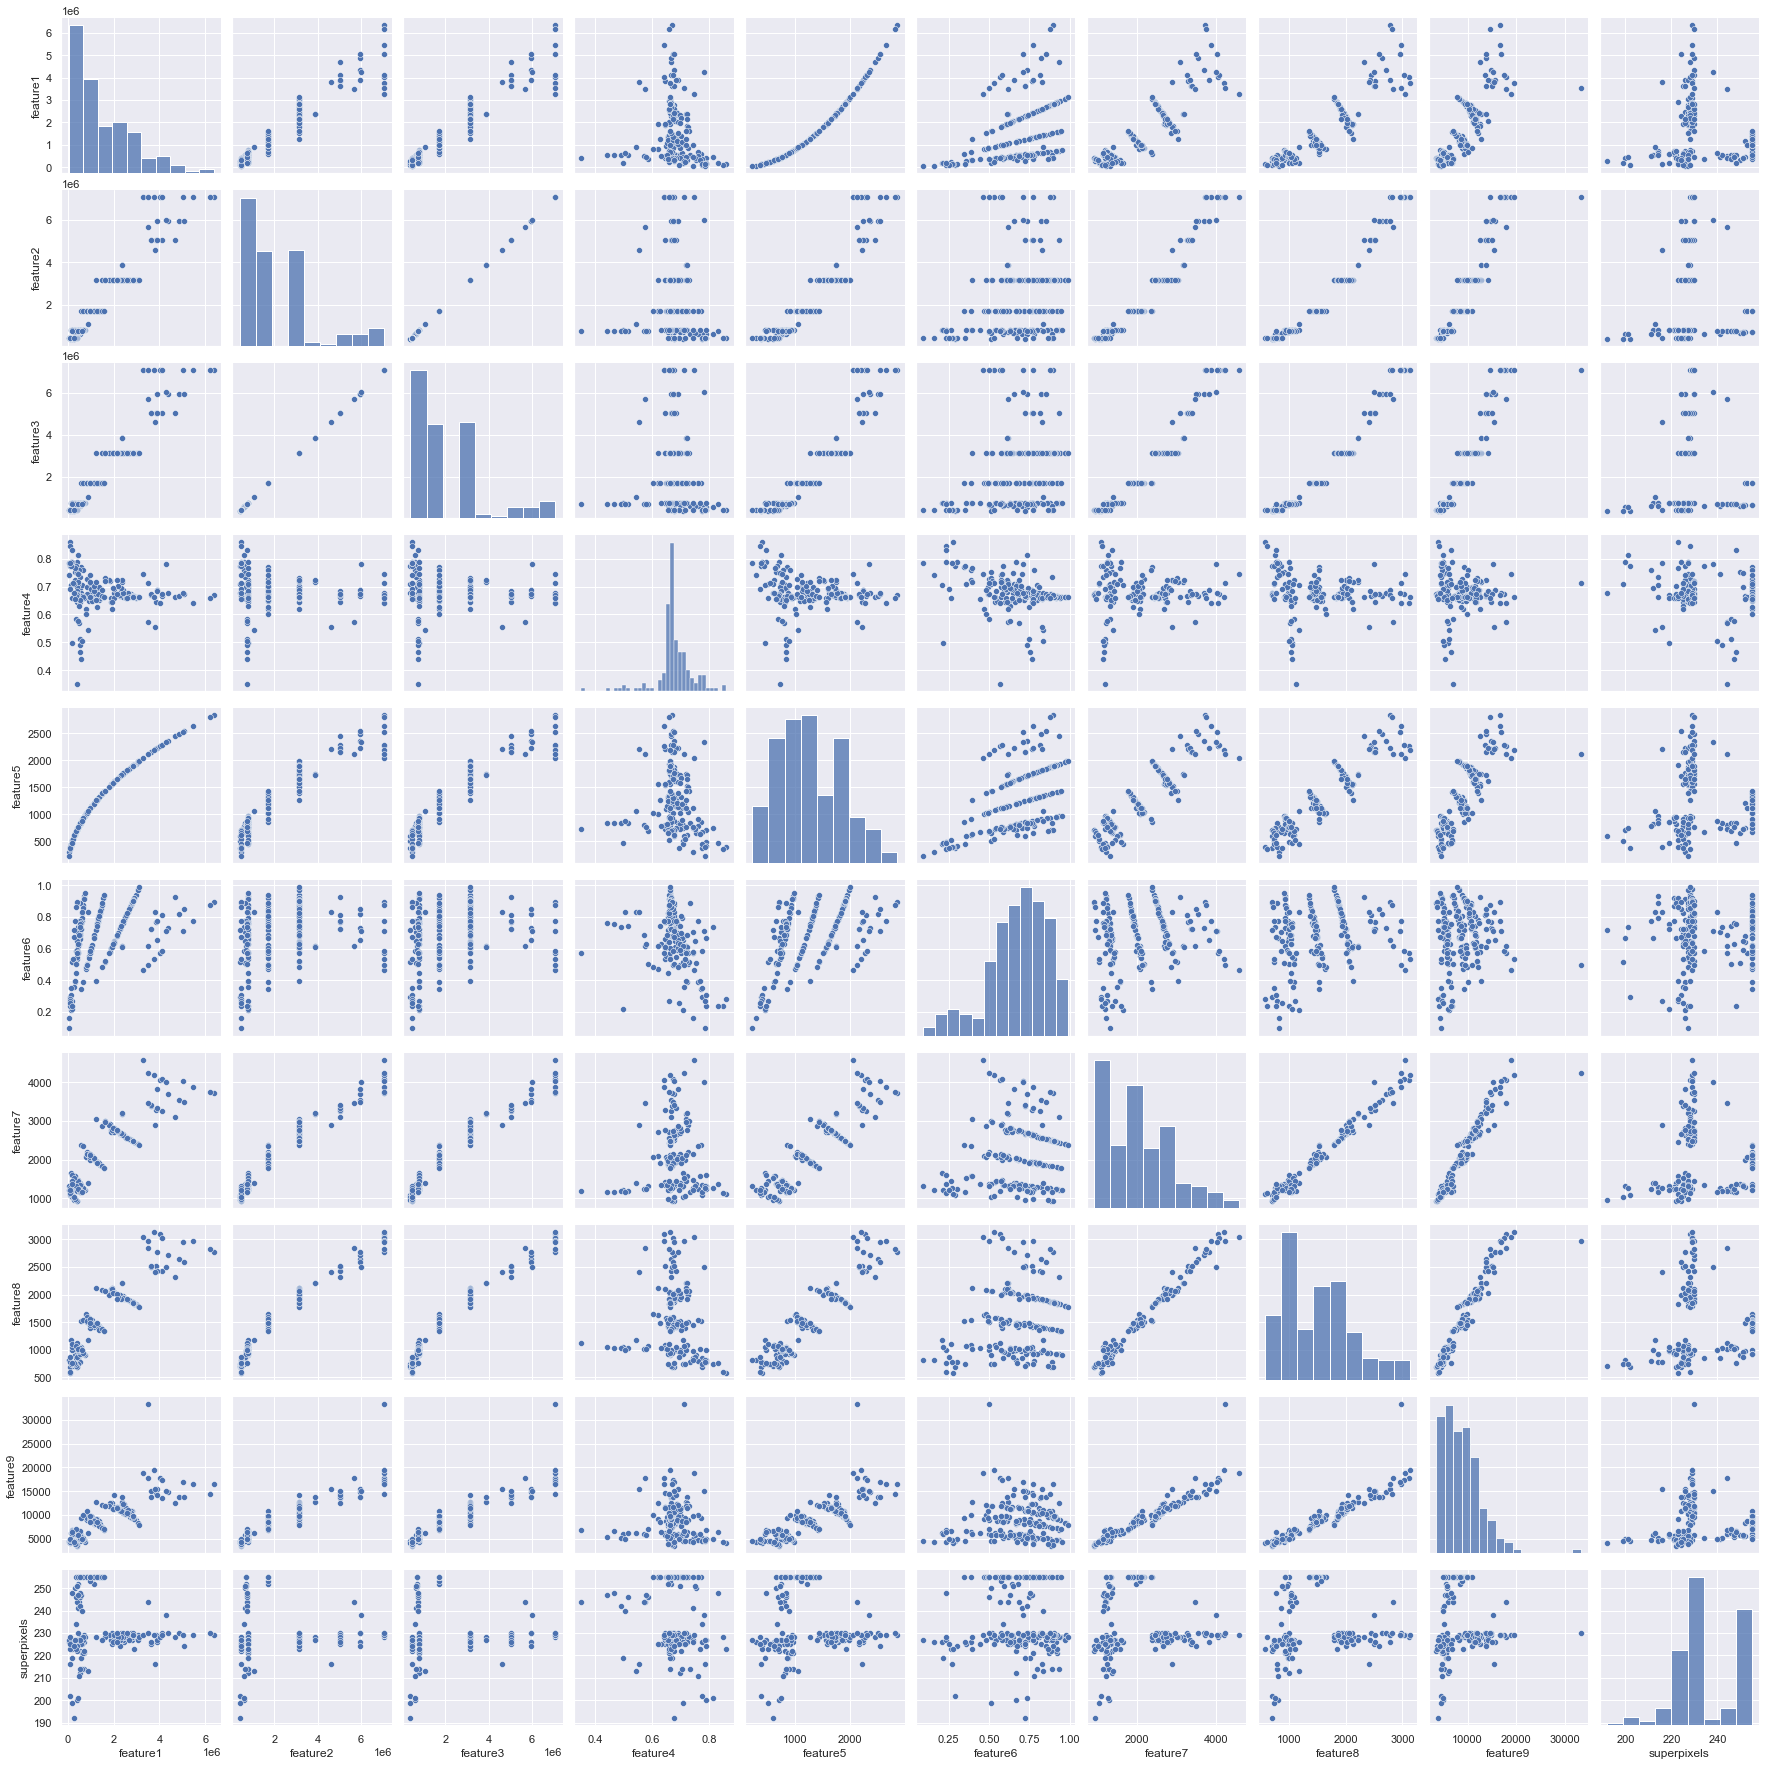

In [13]:
import seaborn as sns
sns.pairplot(df_c)

## Classification

In [14]:
print('start')

# Defining the machine learning models
logistic_m = LogisticRegression() #Logistic regression
tree_m = sklearn.tree.DecisionTreeClassifier(max_depth=3) #Decision tree
gradient_descent_m=SGDClassifier()# stochastic gradient descent
gradient_boosting_m=GradientBoostingClassifier()# gradient boosting
knn_m = sklearn.neighbors.KNeighborsClassifier(n_neighbors=13) #k nearest neighbors
gnb_m = GaussianNB() #Naive bayesian 

start


### Training - Cross validation - Evaluation

In [ ]:
print('learn')
n_samples = 100
accuracy1 = np.zeros(n_samples)
accuracy2 = np.zeros(n_samples)
accuracy3 = np.zeros(n_samples)
accuracy4 = np.zeros(n_samples)
accuracy5 = np.zeros(n_samples)
accuracy6 = np.zeros(n_samples)
for k in range(n_samples):
    print('sample : ', k)
    #splitting data into training and test sets
    random.seed(k)
    X_train, X_test, y_train, y_test = train_test_split(df_c, train_labels, test_size = 0.25)
    
    #Train models with the method .fit()
    model1 = logistic_m.fit(X_train, y_train)
    print('1')
    model2 = tree_m.fit(X_train, y_train)
    print('2')
    model3 = gradient_descent_m.fit(X_train, y_train)
    print('3')
    model4 = gradient_boosting_m.fit(X_train, y_train)
    print('4')
    model5 = knn_m.fit(X_train, y_train)
    print('5')
    model6 = gnb_m.fit(X_train, y_train)
    
    print('predict')
    
    # Predictions are simply computed by the method .predict()
    predictions1 = logistic_m.predict(X_test)
    predictions2 = tree_m.predict(X_test)
    predictions3 = gradient_descent_m.predict(X_test)
    predictions4 = gradient_boosting_m.predict(X_test)
    predictions5 = knn_m.predict(X_test)
    predictions6 = gnb_m.predict(X_test)
    
    print('evaluate')
    
    #Compute accuracy for each model
    accuracy1[k] = accuracy_score(y_test,predictions1)
    accuracy2[k] = accuracy_score(y_test,predictions2)
    accuracy3[k] = accuracy_score(y_test,predictions3)
    accuracy4[k] = accuracy_score(y_test,predictions4)
    accuracy5[k] = accuracy_score(y_test,predictions5)
    accuracy6[k] = accuracy_score(y_test,predictions6)

#Average accuracy of each model   
accuracy1_m = st.mean(accuracy1)
accuracy2_m = st.mean(accuracy2)
accuracy3_m = st.mean(accuracy3)
accuracy4_m = st.mean(accuracy4)
accuracy5_m = st.mean(accuracy5)
accuracy6_m = st.mean(accuracy6)

The data we have is really not sufficient for an efficient classifier, 200 hundred images is not enough, hence, for a credible accuracy value I used cross-validation on 10 samples for every model, the mean value of the accuracy’ values obtained
is considered to evaluate the classifiers then.

### Results

In [16]:
print(['Logitic regression',accuracy1_m])
print(['Decision tree',accuracy2_m])
print(['Gradient descent',accuracy3_m])
print(['Gradient boosting',accuracy4_m])
print(['Knn',accuracy5_m])
print(['Naive Bayesian',accuracy6_m])

['Logitic regression', 0.6376000000000001]
['Decision tree', 0.7324]
['Gradient descent', 0.5544]
['Gradient boosting', 0.7776]
['Knn', 0.7528]
['Naive Bayesian', 0.7306]


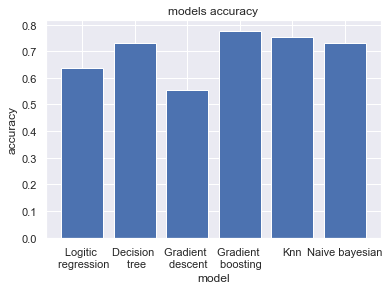

In [17]:
#Plot of accuracy
fig=plt.figure()
plt.bar([1,2,3,4,5,6],height=[accuracy1_m,accuracy2_m,
                              accuracy3_m,accuracy4_m,
                              accuracy5_m,accuracy6_m],
                              tick_label=['Logitic \n regression',
                              'Decision \n tree', 
                              'Gradient \n descent',
                              'Gradient \n boosting', 
                              'Knn','Naive bayesian'])
plt.title('models accuracy')
plt.ylabel('accuracy')
plt.xlabel('model')
plt.show()

\centerline{Accuracy = $77.760$%}

The best model is the Gradient Boosting model, with about $77%$ (around $70%$ before adding the number of superpixels as a feature) accuracy on 10 sampling data using cross-validation. The idea that comes to mind next is combining the geometric descriptors and the color irregularity feature wich is the number of superpixels, unfortunatelyI didn’t have the time to test it since it requires a considerable pre-treatment before running it into Machine learning models.

### visualisation of a sample of the predicted data from the best model with their labels

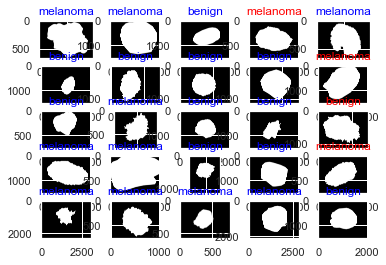

In [18]:
indexes = X_test.index
fig=plt.figure()
for i in range(25):
    a=fig.add_subplot(5,5,i+1)
    if predictions4[i] == y_test[i]:
        col='blue'
    else:
        col= 'red'
    a.set_title(class_names[predictions5[i]],color=col)
    plt.imshow(train_images[indexes[i]],cmap='Greys')
plt.show()

# Classification using a CNN (Convolutional neural network) :

In papers about the original challenge, I read that the best accuracy values (>95%) were obtained using deep learning, so as a bonus method, I decided to use a CNN in order to classify the images.
The biggest problem is that we have really few images, so after splitting the Data we have (112 training images, 50 test images, 38 validation images) which is not enough to evaluate the CNN’s performance and decide of the accurate values for its hyper-parameters.
Another problem is the high dimensions of our images ($767*1022*3$), so passing through a Convolutional layer is like an infinite operation for a normal laptop. To encounter this issue I used only one component of the image resized to smaller dimensions ($84*112$) as input images even if this would remove a considerable part of the information contained in the images.
The details of the layers used and the values of the parameters of this model are in the script which is well commented.

## Deep learning classifier using tensorflow

### Splitting data into training and test data - reshaping

In [19]:
train_images = X_r
train_labels = Y

# Splitting data into training and test data
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size = 0.25)

#Again into validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.25)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_validation = np.array(X_validation)

#reshaping for adequacy with the cnn layers
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)

### Verification

In [20]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('X_validation shape: ', X_validation.shape)

X_train shape:  (112, 84, 112, 1)
X_test shape:  (50, 84, 112, 1)
X_validation shape:  (38, 84, 112, 1)


### CNN Parameters 

In [21]:
batch_size = 32 # You can try 64 or 128 if you'd like to
num_classes = 2
epochs = 84 # loss function value will be stabilized after 93rd epoch# To save the model:
lr = 0.001

input_shape = (84, 112, 1)

#Sequential to concatenate the layers we are willing to add
model = Sequential()

In [22]:
#Three convolutional layers with respectively 8, 16 and 32 neurons
model.add(Conv2D(8, (3, 3), padding="same", kernel_regularizer=l2(0.01), input_shape=input_shape))
#model.add(Conv2D(16, (3, 3), padding="same", kernel_regularizer=l2(0.01), input_shape=input_shape))
model.add(Conv2D(32, (3, 3), padding="same", kernel_regularizer=l2(0.01), input_shape=input_shape))
model.add(Activation("relu"))

#Batch normalization is added to limit changes in the distribution of the input values in a machine
# learning algorithm (Covariate shift).
model.add(BatchNormalization(axis=-1))

#reducing dimension by selecting the Max in each 2*2 window
model.add(MaxPooling2D(pool_size=(2, 2)))
#Dropout take off 15/100 of output values from the last layer in order to avoid overfitting
model.add(Dropout(0.15))

#flatten the layers
model.add(Flatten())

#Adding a normal Dense layer with 16 neurones
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dropout(0.25))

#And finally a normal dense layer with number of outputs the same as the number of classes we have
model.add(Dense(num_classes))
model.add(Activation("softmax"))

#Parametrizing the optimizer of the gradient descent
opt = Adam(lr=lr)

### Compiling the model - Evaluation

In [23]:
#Compiling the model specifying the metrics we want to check
model.compile(loss='categorical_crossentropy', 
              optimizer=opt,
              metrics=['accuracy'])

y_train_c = to_categorical(y_train, num_classes=2, dtype='float32')

In [ ]:
print('start learning')
history=model.fit(X_train.astype("float32"), y_train_c,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_test.astype("float32"), to_categorical(y_test)),
              shuffle=True)

print(history.history)
scores = model.evaluate(X_validation.astype("float32"), to_categorical(y_validation), verbose=0)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

print(history.history.keys())

### Results

Validation loss: 10.32487678527832\
Validation accuracy: 0.6842105388641357\
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
***

Our CNN can achieve very high training accuracy (97%), but still fails with the test Data, since we have not enough Data it is difficult to know the reason behind this issue and correct it, it could be simply by chance due to the low number of test images, same remark for the validation accuracy which is computed on a even smaller set of images.

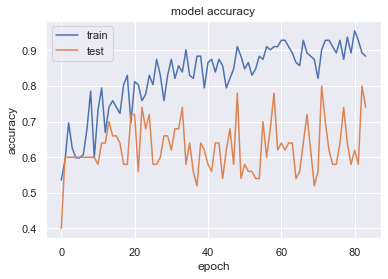

In [25]:
fig=plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

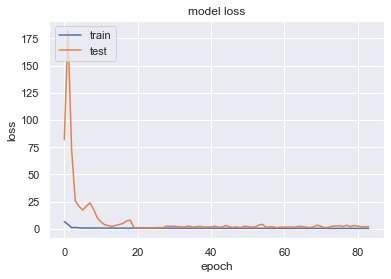

In [26]:
fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Test on the validation Data

In [27]:
predictions = model.predict(X_validation.astype("float32"))
               
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2])


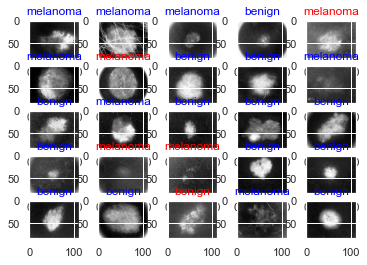

In [28]:
#Visualize results
fig=plt.figure()
for i in range(25):
    a=fig.add_subplot(5,5,i+1)
    t=predictions[i,:]
    
    if np.argmax(t) == y_validation[i]:
        col='blue'
    else:
        col= 'red'
    
    a.set_title(class_names[np.argmax(t)],color=col)
    plt.imshow(X_validation[i],cmap='Greys')
plt.show()

***
A sophisticated visualization with the percentage of belonging to each class in the next Figure

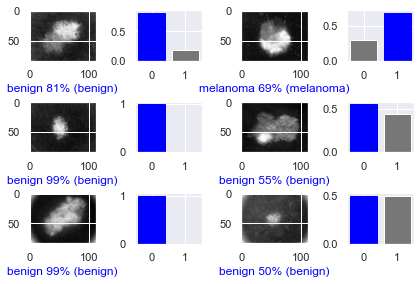

In [29]:
#Sophisticated visualization with percentage of belonging to each class
fig=plt.figure()
k=0
for i in range(10,16):
    plt.subplot(3, 4, 2*k+1)
    plt.imshow(X_validation[i],cmap='Greys')
    
    t=predictions[i,:]
    if np.argmax(t) == y_validation[i]:
        col='blue'
    else:
        col= 'red'
    
    plt.xlabel(class_names[np.argmax(t)]+' '+str(int(100*np.max(t)))+'% ('+class_names[y_validation[i]]+')',color=col)  
       
    plt.subplot(3, 4, 2*k+2)
    bar = plt.bar(range(2), t, color="#777777")
    
    bar[np.argmax(t)].set_color('red')
    bar[y_validation[i]].set_color('blue')
    k=k+1
plt.tight_layout()
plt.show()

Even if it was not very successful in our case due to many reasons, a CNN well settled can be very efficient in an image classification problem.